# Description

## Tasks
Using raw actions to update critic network, check and use scaled/noisy actions to update criti
1. Evaluation Visulaization, improve train visualizations
2. Stochasity of env (modify policy functions)
In visualizations add cumulative rewrad, raw reward, scaled reward episode wise
3. hyperparameter tuning
    1. Soft and hard target network update parameters (tau, alpha, beta, lr)
    2. Network archotecture (layers, neurons, activations, loss func)
    3. weight initilalization
    4. Batch size for memory buffer (For now batch size is set to 1 which is not enough, increase batch size to 64 at elast and train algorihim for at elast 10xbatch_size steps)
4. Rewrad function (liquidity utilization, capital efficiency) 
Explore sparse and delayed rewrds to handle mutiple positions
5. Redefine obs space(For start just add balance of token0, balance of token1, tvlUSD, and latter consider Include tick, position data)
6. Predict the trained model with real data of uniswap pools (make action sapce scaling/clipping compliant with this req)
### Action space
1. Curently using restrictions on both price_upper and lower (requires very small training)
2. Use min max limits for actions only, then handle invlaid actions
3. Let agent explore action space without any bounds (will take a lot of training)
#### Negative rewrad approach (Ideal)
sepcify upper and lower bounds of actions around curr_price but dont need to scale action around curr_price (we are doing this to ensure that actions are valid price_lower!>price_upper) as it will make it impossible for agent to place limit orders. to handle this issue we can introduce a big negative reward in our step functions for invalid functions and terminate the episode to avoid learning instability due to big negative reward
Change activation of output layer to tanh from sigmoid
price_lower=c_p - c_p*a_0
price_upper=c_p +c_p*a_1
clipp price_lower and price_upper by min and max bounds

if price_lower > price_upper:
        return self.state, -BIG_PENALTY, True, {}
#### Parameterizing Actions with a Base and Offset (doesn't make sense)
base_price is predicted directly by the network. tanh activation
offset is predicted by the network but constrained to be positive (e.g., using a softplus activation function).
Then:
scaled_base_price=min_price+(max_price−min_price)×raw_base_price
scaled_offset=(2×raw_offset−1)×max_offset
price_lower=scaled_base_price−scaled_offset/2
price_upper=scaled_base_price+scaled_offset/2

### Obs space
0. Add a feature which depicts liquidity distribution around current tick instaed of giving complete data of ticks/positions in obs space. Engineeer a feature which does reflects distribution of liq in the pool
1. feehrowth0 and feegrowth1 is already representing the swaps so no need to add swap data
2. liquidity variable is representing the mint and burn events (regardless of position) so adding tick data will give him info about range of liquidity added which will make obs sapce more rich and learn complex dynamcis of pool (slippage, fee share, etc)
#### Relative change feature ((curr_value-previous_value)/previous_value)
instead of using absoulte value use of relative features ((curr_value-previous_value)/previous_value) ensures that model learns relatioship between changes in features instead of focusing on their absolute values. The problem with current obs space is that we are losing absoulte info specifically  (liq and fee growth), which could be crucial for agent to learn dynamics of differnt type of pools. e.g a pool with lower liqudity dpeth has differnt dynamics than a pool with higher liqudity depth but by enginering this relative liquidity parameter we are lsoing that information which could be crucial.
#### Running Statistics and Z-Score Scaling (mean_std deviation)
It provides the agent with information about both the absolute levels and deviations from the mean of each feature.
It allows you to control the scale of the observations using parameters like alpha for EWMA and clipping to keep values within a specific range.
Use ewma features which capture the secure the information of absolute features

## Improvements
1. MARL
2. Multi env training
## Baseline Models to comapre startegies
0. Random agent which takes random actions can be used as baseline of start
1. +-10% around current price (retail_aggressive)
2. +-20% around current price (retail_safe)
3. grid strategy (x amount divided in y levels of +-10%, 15%, 20% around current price with amount expoennetially decreasing as position gets wider )

## Mulriple positions
Explore sparse and delayed rewards
1. To handle mutiple positions we can use output layer which outputs multiple actions with probabilities e.g range x1,y1 0.6, x2,y2 0.3 etc
2. Using mutiple agents, each initialized with differnt type of state space and action space (applying differnt constraints on action for aggresive and defensive actions)
For multiple positions rl agent we can use netlists for evaluation in eval mode and use engine.run to evaluate policy but now as we have only one position so need to modify LPagent and swapper agent a lot as they dont add and remove liq in same step

## More dynamic env setup(done)
At start of each episode we can initialze new pool with differnt dynamics (initial price, liq depth, volatility, types of assets, fees structure etc) to capture more real world pool dynamics. This will help agent to learn more generic policy, for diffrent type of pools(low/high depth, stable/volatile asset pools etc)
Sync pool is necessary to apply this approach of differnt pool in each episode
To simulate differnt dynamics in each pool, we can initilize each pool with differnt type of assets(satble, volatile), fees (0.3%, 0.1%, 1%) and also using abm to initialze pool before feeding to RL agent (initialize a new pool and then simulate it for (100/200/300) steps to capture differnt types of dynamics of pool and can also customize policies for differnt types of pools). Because A pool 10 days old has differnt dynamics than 1000 dyas old pool and A pool with x Liquidty depth has differnt dynamics than a pool with y liq depth..........

Squashing Functions: Functions like the hyperbolic tangent (tanh) can be used to squash values into a range between -1 and 1. This can then be rescaled to any desired range. The function is smooth and differentiable, ensuring nice properties for optimization.

Soft Clipping with a Penalty: Instead of using a function to squash values, you can introduce a penalty in the loss function for values that approach or exceed the boundaries. The penalty grows larger as the value moves further from the desired range, encouraging the model to stay within bounds without enforcing a strict cutoff.

Sigmoid-Based Rescaling: Similar to the tanh approach, you can use the sigmoid function to squash values between 0 and 1 and then rescale to the desired range.

# Reset Env

In [1]:
import shutil
import os
import json

# Define the paths
folder_path = "/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/v3_core/build/deployments"
json_file1_path = "/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/token_pool_addresses.json"
json_file2_path = "/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/liq_positions.json"

# 1. Delete the folder and its contents
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

# 2. Delete contents of the first JSON file
with open(json_file1_path, 'w') as file:
    file.write("{}")

# 3. Delete contents of the second JSON file and add {}
with open(json_file2_path, 'w') as file:
    file.write("{}")

"Simulation reset operations completed successfully."


'Simulation reset operations completed successfully.'

In [ ]:
# run ganache and compile contracts using tsp coomand line interface
'''
import subprocess
ret_code = subprocess.call("tsp ganache", shell=True)

result = subprocess.run("tsp ganache", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(f'Standard Output:\n{result.stdout}')
print(f'Standard Error:\n{result.stderr}')

result = subprocess.run("tsp compile", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(f'Standard Output:\n{result.stdout}')
print(f'Standard Error:\n{result.stderr}')
'''

# Setup

In [1]:
import os
os.chdir('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice')
os.environ["PATH"] += ":."

In [2]:
from netlists.uniswapV3.netlist import SimStrategy,SimState,netlist_createLogData
from engine.SimEngine import SimEngine
from util.globaltokens import weth_usdc_pool,eth_dai_pool,btc_usdt_pool

Existing pool:WETH_USDC_3000 having pool address: 0xd31345e093D22Fc38Ec6494dac46c32A21dd0C7a loaded
Existing pool:ETH_DAI_3000 having pool address: 0x3039E20eC3aD9CEC5E6658115cB44f76BA467421 loaded
Existing pool:BTC_USDT_3000 having pool address: 0x52D457135ED8fd28ec37791dc100b7686ad33C4C loaded


In [3]:
import tensorflow as tf
import gym
from util.constants import GOD_ACCOUNT
from util.base18 import toBase18, fromBase18,fromBase128,price_to_valid_tick 
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import stable_baselines3
from stable_baselines3 import PPO

from gym import spaces
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete,Space

2023-10-23 12:13:28.164683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 12:13:28.164846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 12:13:28.165157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 12:13:28.344762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 12:14:33.190621: W tensorflow/compiler/

# DDPG Model with Dict Spaces ENv

## DDPG agent env

In [99]:
class DiscreteSimpleEnv(gym.Env):
    def __init__(self,agent_budget_usd):
        super(DiscreteSimpleEnv, self).__init__()

        self.pool=None
        self.global_state=None
        self.curr_price=None
        self.action_lower_bound=None
        self.action_upper_bound=None
        self.state=None
        self.engine=None
        
        self.action_space = gym.spaces.Dict({
            'price_relative_lower': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            'price_relative_upper': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
        })
        
        self.reward=0
        self.cumulative_reward = 0
        self.done=False
        self.episode=0
        self.step_count=0

        self.observation_space = gym.spaces.Dict({
            'scaled_curr_price': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_liquidity': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_feeGrowthGlobal0x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'scaled_feeGrowthGlobal1x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),   
        })
        self.agent_budget_usd = agent_budget_usd

        # Initialize rewrad normalization running statistics
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0

        self.exploration_std_dev = 0.01
        self.penalty=0

        # Initialize running statistics for state normalization
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0
        self.alpha = 0.9
        

    def reset(self):
        self.pool=weth_usdc_pool#random.choice([weth_usdc_pool,eth_dai_pool,btc_usdt_pool])
        
        print(f'Pool selcted for this episode: {self.pool.pool_id}')
        sim_strategy = SimStrategy()
        sim_state = SimState(ss=sim_strategy,pool=self.pool)

        output_dir = "model_outdir_csv"
        netlist_log_func = netlist_createLogData

        #from engine.SimEngine import SimEngine
        self.engine = SimEngine(sim_state, output_dir, netlist_log_func)

        self.global_state=self.pool.get_global_state()
        self.curr_price=self.global_state['curr_price']
        self.action_lower_bound=self.curr_price*0.1
        self.action_upper_bound=self.curr_price*2
        self.state = self.get_obs_space()
        
        self.done=False
        self.reward=0
        self.cumulative_reward = 0
        self.episode+=1
        self.step_count=0

        # reset running statistics for reward normalization
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0

        # reset running statistics for state normalization
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0
        
        
        return self.state


    def step(self, raw_action):
              
        # Execute agent's action using pool's interface of add/remove liquidity
        mint_tx_receipt,action=self._take_action(raw_action)
        
        # run uniswap abm env of n_steps
        print()
        print('Environment Step')
        self.engine.reset()
        self.engine.run()
        print()
        
        self.state=self.get_obs_space()

        self.reward,raw_reward,fee_income,impermanent_loss = self._calculate_reward(action,mint_tx_receipt)
        self.cumulative_reward += self.reward

        # Assume the episode is done after some arbitrary condition
        self.step_count+=1
        
        print(f"episode: {self.episode}, step_count: {self.step_count}, scaled_reward: {self.reward}, raw_reward: {raw_reward} cumulative_reward: {self.cumulative_reward}")
        print(f"raw_pool_state: {self.pool.get_global_state()}")
        print(f"sclaed_pool_state: {self.state}")
        print()

        train_data_log.append((self.episode, self.step_count, action, self.pool.get_global_state(), raw_action, self.state, raw_reward, self.reward, self.cumulative_reward, fee_income, impermanent_loss))

        self.done = self._is_done()
        return self.state, self.reward, self.done, {}

    def get_obs_space(self):
        self.global_state = self.pool.get_global_state()

        # Scaling for curr_price and liquidity
        curr_price = float(self.global_state['curr_price'])
        liquidity = float(self.global_state['liquidity_raw'])

        self.curr_price_mean = self.alpha * curr_price + (1 - self.alpha) * self.curr_price_mean
        self.curr_price_std = np.sqrt(self.alpha * (curr_price - self.curr_price_mean)**2 + (1 - self.alpha) * self.curr_price_std**2)

        self.liquidity_mean = self.alpha * liquidity + (1 - self.alpha) * self.liquidity_mean
        self.liquidity_std = np.sqrt(self.alpha * (liquidity - self.liquidity_mean)**2 + (1 - self.alpha) * self.liquidity_std**2)

        obs = {
            'scaled_curr_price': (curr_price - self.curr_price_mean) / (self.curr_price_std + 1e-10),
            'scaled_liquidity': (liquidity - self.liquidity_mean) / (self.liquidity_std + 1e-10),
        }

        # Scaling for fee growth differences
        fee_growth_0 = float(self.global_state['feeGrowthGlobal0X128'])
        fee_growth_1 = float(self.global_state['feeGrowthGlobal1X128'])

        self.fee_growth_diff_0 = fee_growth_0 - self.previous_fee_growth_0
        self.fee_growth_diff_1 = fee_growth_1 - self.previous_fee_growth_1

        self.fee_growth_0_mean = self.alpha * self.fee_growth_diff_0 + (1 - self.alpha) * self.fee_growth_0_mean
        self.fee_growth_0_std = np.sqrt(self.alpha * (self.fee_growth_diff_0 - self.fee_growth_0_mean)**2 + (1 - self.alpha) * self.fee_growth_0_std**2)

        self.fee_growth_1_mean = self.alpha * self.fee_growth_diff_1 + (1 - self.alpha) * self.fee_growth_1_mean
        self.fee_growth_1_std = np.sqrt(self.alpha * (self.fee_growth_diff_1 - self.fee_growth_1_mean)**2 + (1 - self.alpha) * self.fee_growth_1_std**2)

        obs['scaled_feeGrowthGlobal0x128'] = (self.fee_growth_diff_0 - self.fee_growth_0_mean) / (self.fee_growth_0_std + 1e-10)
        obs['scaled_feeGrowthGlobal1x128'] = (self.fee_growth_diff_1 - self.fee_growth_1_mean) / (self.fee_growth_1_std + 1e-10)

        self.previous_fee_growth_0 = fee_growth_0
        self.previous_fee_growth_1 = fee_growth_1

        return obs

    def _take_action(self, action):
        self.penalty=0

        raw_a, raw_b = action[0, 0].numpy(), action[0, 1].numpy()

        # Add exploration noise
        
        a_0 = raw_a + np.random.normal(0, self.exploration_std_dev)
        a_1 = raw_b + np.random.normal(0, self.exploration_std_dev)

        a_0 = np.clip(a_0, 0, 1)
        a_1 = np.clip(a_1, 0, 1)

        
        # Only enabling agent to provide liquiidty around bounds midpoint
        price_lower = self.action_lower_bound + a_0 * (self.action_upper_bound - self.action_lower_bound)/2
        price_upper = (self.action_upper_bound - self.action_lower_bound)/2 + a_1 * (self.action_upper_bound - self.action_lower_bound)/2

        '''
        # Enabling agent to place range orders too
        price_lower = self.action_lower_bound + a_0 * (self.action_upper_bound - self.action_lower_bound)
        price_upper = self.action_lower_bound + a_1 * (self.action_upper_bound - self.action_lower_bound)
        '''
        # Ensure price_lower is less than price_upper - Add penalty
        if price_lower>price_upper:
            price_lower = min(price_lower, price_upper)
            price_upper = max(price_lower, price_upper)
            self.penalty=-10

        # ensure actions are not too close - Add penalty
        min_diff_percentage = 0.05  # 5% difference
        price_diff = price_upper - price_lower
        if price_diff < min_diff_percentage * price_lower:
            self.penalty+=-10
            price_upper = price_lower + min_diff_percentage * price_lower

        action_dict = {
            'price_lower': price_lower,
            'price_upper': price_upper
        }
        
        print('Agent Action')
        print(f"raw_action: {action}, scaled_action: {action_dict}, noisy_action: [{a_0,a_1}]")

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd

        mint_tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return mint_tx_receipt,action_dict
        
    def _calculate_reward(self,action,mint_tx_receipt):
       
        tick_lower=price_to_valid_tick(action['price_lower'],60)
        tick_upper=price_to_valid_tick(action['price_upper'],60)
        liquidity=mint_tx_receipt.events['Mint']['amount']

        # Collecting fee earned by position
        print('Collect fee')
        collect_tx_receipt,fee_income = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper,poke=True)
    
        print("Burn Position and Collect Tokens")
        # Remove position and collect tokens
        burn_tx_receipt=self.pool.remove_liquidity_with_liquidty(GOD_ACCOUNT, tick_lower, tick_upper, liquidity)
        collect_tx_receipt,_ = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper,poke=False)
        
        # Calculate IL
        amount0_initial = mint_tx_receipt.events['Mint']['amount0']
        amount1_initial = mint_tx_receipt.events['Mint']['amount1']
        
        amount0_final = burn_tx_receipt.events['Burn']['amount0']
        amount1_final = burn_tx_receipt.events['Burn']['amount1']
        self.global_state = self.pool.get_global_state()
        pool_price = float(self.global_state['curr_price'])

        value_initial = (amount0_initial * pool_price + amount1_initial) / 1e18
        value_final = (amount0_final * pool_price + amount1_final) / 1e18

        impermanent_loss = value_initial - value_final
        
        #capital_efficiency = self.pool.calculate_capital_efficiency(tick_lower, tick_upper)
        #gas_cost = self.pool.estimate_gas_cost(action)
        print(f'fee_earned:{fee_income}, impermannet_loss: {impermanent_loss},penalty: {self.penalty}')
        print()
        raw_reward = fee_income - impermanent_loss + self.penalty # + capital_efficiency - gas_cost

        self.reward_count += 1
        new_mean = self.reward_mean + (raw_reward - self.reward_mean) / self.reward_count
        new_std = ((self.reward_std ** 2 + (raw_reward - self.reward_mean) * (raw_reward - new_mean)) / self.reward_count) ** 0.5

        self.reward_mean = new_mean
        self.reward_std = new_std

        self.reward = (raw_reward - self.reward_mean) / (self.reward_std + 1e-10)
    
        return self.reward,raw_reward,fee_income, impermanent_loss

    def _is_done(self):
        
        max_threshold = 500
        min_threshold= -500  
        if self.cumulative_reward >= max_threshold or self.cumulative_reward<=min_threshold:
            return True
        else:
            return False


## DDPG Agent Model

In [100]:
class ReplayBuffer:
    def __init__(self, max_size, input_dims, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, input_dims))
        self.new_state_memory = np.zeros((self.mem_size, input_dims))
           
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):

        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1
        #print(f"action_memory:{self.action_memory}")


    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

class Actor(tf.keras.Model):
    def __init__(self, n_actions):
        super(Actor, self).__init__()

        self.fc1 = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(300, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='sigmoid')  # Two output units for 'price_lower' and 'price_upper'

    def call(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        
        # Use the modified output layer
        actions = self.output_layer(x)
        
        return actions
        
class Critic(tf.keras.Model):
    def __init__(self, n_actions):
        super(Critic, self).__init__()
        self.fc1 = tf.keras.layers.Dense(400, activation='relu')
        
        self.fc2 = tf.keras.layers.Dense(300, activation='relu')
        
        self.q = tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action):
        x = tf.concat([state, action], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.q(x)
        return q
    
class DDPG:
    def __init__(self, alpha=0.001, beta=0.002, input_dims=[8], tau=0.005, env=None,
                 gamma=0.99, n_actions=2, max_size=1000000, layer1_size=400, 
                 layer2_size=300, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = Actor(n_actions=n_actions)
        self.critic = Critic(n_actions=n_actions)

        self.target_actor = Actor(n_actions=n_actions)
        self.target_critic = Critic(n_actions=n_actions)

        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

        self.env = env

        # For tensorboard logging
        self.log_dir = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/tensorboard_logs'
        self.train_summary_writer = tf.summary.create_file_writer(self.log_dir)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):

        flat_state = self.flatten_state(state)
        flat_action = self.flatten_action(action)
        flat_new_state = self.flatten_state(new_state)
        self.memory.store_transition(flat_state, flat_action, reward, flat_new_state, done)
        

    def flatten_state(self,state_dict):
        scaled_curr_price = float(state_dict['scaled_curr_price'])
        scaled_liquidity = float(state_dict['scaled_liquidity'])
        scaled_fee_growth_0 = float(state_dict['scaled_feeGrowthGlobal0x128'])
        scaled_fee_growth_1 = float(state_dict['scaled_feeGrowthGlobal1x128'])
        
        return np.array([scaled_curr_price, scaled_liquidity, scaled_fee_growth_0, scaled_fee_growth_1])

    def unflatten_state(self,state_array):
        return {
            'scaled_curr_price': state_array[0],
            'scaled_liquidity': state_array[1],
            'scaled_feeGrowthGlobal0x128': state_array[2],
            'scaled_feeGrowthGlobal1x128': state_array[3]
        }

    def flatten_action(self,action):
        return tf.reshape(action, [-1])

    def unflatten_action(self,action):
        return tf.reshape(action, [1, -1])
    
    def choose_action(self, state):
        state_dict = state
        state_dict_float = {
            key: float(value) for key, value in state_dict.items()
        }

        state_array = np.array(list(state_dict_float.values()), dtype=np.float32)
        state_array = state_array.reshape(1, -1)
        state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)

        raw_actions_tensor = self.actor(state_tensor)
        
        return raw_actions_tensor

        
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)
        
        #print(f"{state},{action},{reward},{new_state}")
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)


        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_)
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = tf.keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss, 
                                            self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, 
                                    self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))
        
        print(f"Actor_Loss: {actor_loss.numpy()}, Critic_Loss: {critic_loss.numpy()}")
       
        with self.train_summary_writer.as_default():
            tf.summary.scalar('critic_loss', critic_loss.numpy(), step=self.memory.mem_cntr)
            tf.summary.scalar('actor_loss', actor_loss.numpy(), step=self.memory.mem_cntr)


        self.update_network_parameters()

## Train

In [101]:
train_data_log=[]
env=DiscreteSimpleEnv(agent_budget_usd=1000)

n_actions = sum(action_space.shape[0] for action_space in env.action_space.values())

input_dims = sum(np.prod(env.observation_space.spaces[key].shape) for key in env.observation_space.spaces.keys())

agent = DDPG(alpha=0.001, beta=0.002, input_dims=input_dims, tau=0.2, env=env,
             n_actions=n_actions, layer1_size=400, layer2_size=300, batch_size=5)


In [ ]:
n_episodes = 1
max_steps = 30

for i in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    
    for _ in range(max_steps):
        action = agent.choose_action(state)

        next_state, reward, done, _ = env.step(action)
        
        agent.remember(state, action, reward, next_state, done)
        agent.learn()

        state = next_state
        episode_reward += reward
        
        if done:
            break

    print(f"Episode {i+1}: Reward = {episode_reward}")

# agent.save_model()


## Training Visulizations

### Sort data for visulaizations

In [18]:
df_data = []

for entry in train_data_log:
    episode, step_count, scaled_action, raw_state, tensor_data, scaled_state, raw_reward, scaled_reward, cumulative_reward, fee_earned, impermanent_loss = entry
    
    # Extract raw_action values from tensor_data
    raw_action_0 = float(tensor_data[0][0].numpy())
    raw_action_1 = float(tensor_data[0][1].numpy())
    
    # Combine all data into a single dictionary
    data = {
        'episode': episode,
        'step_count': step_count,
        'raw_reward': raw_reward,
        'scaled_reward': scaled_reward,
        'fee_earned': fee_earned,
        'impermanent_loss': impermanent_loss,
        'cumulative_reward': cumulative_reward,
        'raw_action_0': raw_action_0,
        'raw_action_1': raw_action_1,
    }
    
    # Add raw_action, global_state, and state data
    data.update(scaled_action)
    data.update(raw_state)
    data.update(scaled_state)
    
    df_data.append(data)

data_df = pd.DataFrame(df_data)
data_df.to_csv('model_outdir_csv/rl_agent_train_data.csv', index=False)
data_df


,episode,step_count,raw_reward,scaled_reward,fee_earned,impermanent_loss,cumulative_reward,raw_action_0,raw_action_1,price_lower,...,feeGrowthGlobal0X128,feeGrowthGlobal1X128,liquidity_raw,blockTimestamp,tickCumulative,secondsPerLiquidityCumulativeX128,scaled_curr_price,scaled_liquidity,scaled_feeGrowthGlobal0x128,scaled_feeGrowthGlobal1x128
0,1,1,-0.128386,0.000000,0.059023,0.187409,0.000000,0.509054,0.476191,1070.323404,...,85566644851684479080672688029777198,170103480958522848614823760016651767105,66702854773523263050000,1703491373,2602948066644779,226390187377382437069573648,0.262046,0.289972,-0.994166,-0.994490
1,1,2,0.041879,0.119532,0.061522,0.019643,0.119532,0.526164,0.497047,1124.686456,...,85706690132698980392138829102627355,170230684332017176354289635336227182189,67606191948894620170000,1703750650,2602967512593522,226391504724798780832706385,0.024984,0.223318,-0.304419,-0.299058
2,1,3,0.046004,0.143960,0.048053,0.002049,0.263492,0.511227,0.498779,1082.255172,...,85781365896994333403632190963401607,170408005300020254953743724464871424752,68011851978892665860000,1704009933,2602986973508539,226392801132203474289724061,0.068228,0.250485,-0.103882,-0.091106
3,1,4,-0.025842,-0.044770,0.049488,0.075330,0.218723,0.507902,0.498630,1097.682319,...,85799220014269643799157821142897358,170691806691779867373932647923557793499,69762601598906078740000,1704269223,2603006436766047,226394085648678980500977051,0.784183,0.975776,-0.055000,-0.007914
4,1,5,-0.109640,-0.746905,0.058402,0.168042,-0.528183,0.518556,0.500558,1104.334479,...,85799220014269643799157821142897358,171071096342968969779406014414650177512,69268701077419649990000,1704528493,2603025936375681,226395356471702278115646339,1.018432,-0.477895,-0.039418,0.056671
5,1,6,0.067959,1.535655,0.068489,0.000529,1.007472,0.493750,0.538855,1052.572929,...,85927147864373535204759606229319484,171331401719241156511023175865867025286,68336322708604902010000,1704787755,2603045450077153,226396640083959456637535513,0.453999,-1.028180,0.442001,-0.210882
6,1,7,0.011253,1.066927,0.043370,0.032117,2.074399,0.492546,0.543459,1066.325571,...,86058212508447259862473952300132885,171399737768519189978938615495643929646,68294250713939784430000,1705047022,2603064964499600,226397938581951914342748801,-1.016516,-0.424419,0.172563,-0.800993
7,1,8,0.058316,2.498526,0.061219,0.002903,4.572925,0.489793,0.567806,1066.297622,...,86160553963467862768178879557844955,171641522896365892372104579284276061294,67392896914914830230000,1705306290,2603084474589202,226399233098130828956392080,0.565149,-1.046739,-0.705493,0.923041
8,1,9,-0.005195,-0.040988,0.061610,0.066805,4.531937,0.438439,0.664750,999.266419,...,86218540164312768148897800830684231,172013579273993857479155423720006730955,67392896914914830230000,1705565559,2603104014740998,226400539919172183246827122,1.050935,-0.330399,-1.016972,0.985383
9,1,10,-0.010043,-1.514591,0.037551,0.047593,3.017347,0.447662,0.739683,970.816849,...,86240175211935168729479837898671196,172284224289109780085515036501638134456,67392896914914830230000,1705824828,2603123579696484,226401846469549835357733931,1.001521,-0.131701,-0.986726,-0.916938


### Plot

In [10]:
def plot_agent_performance_combined(data_df):
    
    episodes = data_df['episode'].unique()
    episode_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'cyan', 'yellow', 'grey']

    data_df['action_midpoint'] = (data_df['price_lower'] + data_df['price_upper']) / 2
    data_df['action_range'] = data_df['price_upper'] - data_df['price_lower']

    data_df['extended_step_count'] = data_df.groupby('episode').cumcount()

    for i in range(1, len(episodes)):
        data_df.loc[data_df['episode'] == episodes[i], 'extended_step_count'] += data_df[data_df['episode'] == episodes[i-1]]['extended_step_count'].max() + 1

    # Plotting with the extended step count
    fig, ax1 = plt.subplots(figsize=(15, 7))
    for episode, color in zip(episodes, episode_colors):
        episode_data = data_df[data_df['episode'] == episode]
        ax1.fill_between(episode_data['extended_step_count'], episode_data['action_midpoint'] - episode_data['action_range']/2, 
                        episode_data['action_midpoint'] + episode_data['action_range']/2, color=color, alpha=0.2)
        ax1.plot(episode_data['extended_step_count'], episode_data['curr_price'], label=f'Episode {episode} Curr Price', color=color, linestyle='--')

    ax1.set_xlabel('Extended Step Count')
    ax1.set_ylabel('Price')
    ax1.set_title('Agent Actions Over Extended Time')
    ax1.legend(loc='upper left')

    # Create a secondary y-axis for rewards
    ax2 = ax1.twinx()
    for episode, color in zip(episodes, episode_colors):
        episode_data = data_df[data_df['episode'] == episode]
        ax2.plot(episode_data['extended_step_count'], episode_data['scaled_reward'], linestyle=':', label=f'Episode {episode} Scaled Reward', color=color)
        ax2.plot(episode_data['extended_step_count'], episode_data['raw_reward'], linestyle='-.', label=f'Episode {episode} Raw Reward', color=color)
    ax2.set_ylabel('Reward')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# The starting point for each new episode will be the maximum step count of the previous episode
    for i in range(1, len(episodes)):
        data_df.loc[data_df['episode'] == episodes[i], 'extended_step_count'] += data_df[data_df['episode'] == episodes[i-1]]['extended_step_count'].max() + 1

    # Plotting with the extended step count
    plt.figure(figsize=(15, 7))
    for episode, color in zip(episodes, episode_colors):
        episode_data = data_df[data_df['episode'] == episode]
        plt.plot(episode_data['extended_step_count'], episode_data['action_midpoint'], label=f'Episode {episode} Midpoint', color=color)
        plt.fill_between(episode_data['extended_step_count'], episode_data['action_midpoint'] - episode_data['action_range']/2, 
                        episode_data['action_midpoint'] + episode_data['action_range']/2, color=color, alpha=0.2)
        plt.plot(episode_data['extended_step_count'], episode_data['curr_price'], label=f'Episode {episode} Curr Price', color=color, linestyle='--')

    plt.title('Agent Actions Over Extended Time')
    plt.xlabel('Extended Step Count')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculating the midpoint of the action
    data_df['action_midpoint'] = (data_df['price_lower'] + data_df['price_upper']) / 2
    data_df['action_range'] = data_df['price_upper'] - data_df['price_lower']
    

    # Plotting
    plt.figure(figsize=(15, 7))
    for episode, color in zip(episodes, episode_colors):
        episode_data = data_df[data_df['episode'] == episode]
        plt.plot(episode_data['step_count'], episode_data['action_midpoint'], label=f'Episode {episode} Midpoint', color=color)
        plt.fill_between(episode_data['step_count'], episode_data['action_midpoint'] - episode_data['action_range']/2, 
                        episode_data['action_midpoint'] + episode_data['action_range']/2, color=color, alpha=0.2)
        plt.plot(episode_data['step_count'], episode_data['curr_price'], label=f'Episode {episode} Current Price', color=color, linestyle='--')

    plt.title('Agent Actions and Current Prices Over Time')
    plt.xlabel('Step Count')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Separate data for each episode
    
    color_map = plt.get_cmap('tab10')
    
    # Agent Actions and Rewards over Time
    fig, ax1 = plt.subplots(figsize=(15, 5))
    for i, episode in enumerate(episodes):
        episode_df = data_df[data_df['episode'] == episode]
        ax1.plot(episode_df['step_count'], episode_df['curr_price'], label=f'Episode {episode} Current Price', color=color_map(i))
    ax1.set_xlabel('Step Count')
    ax1.set_ylabel('Price')
    ax1.set_title('Agent Actions and Rewards over Time')
    ax1.legend()
    plt.tight_layout()
    plt.show()
    
    # Agent Actions and Color-coded Rewards over Time
    fig, ax = plt.subplots(figsize=(14, 7))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        ax.fill_between(episode_data['step_count'], episode_data['price_lower'], episode_data['price_upper'], color=color_map(i), alpha=0.5, label=f'Episode {episode} Action Range')
    ax.set_title('Agent Actions Over Time')
    ax.set_xlabel('Step Count')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Distribution of Raw and Scaled Rewards
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        axes[0].hist(episode_data['raw_reward'], bins=50, color=color_map(i), alpha=0.7, label=f'Episode {episode}')
        axes[1].hist(episode_data['scaled_reward'], bins=50, color=color_map(i), alpha=0.7, label=f'Episode {episode}')
    axes[0].set_title('Distribution of Raw Rewards')
    axes[1].set_title('Distribution of Scaled Rewards')
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    # Fee Income and Impermanent Loss Over Time
    fig, ax = plt.subplots(figsize=(15, 6))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        ax.plot(episode_data['fee_earned'], label=f'Episode {episode} Fee Income', color=color_map(i))
        ax.plot(episode_data['impermanent_loss'], linestyle='--', label=f'Episode {episode} Impermanent Loss', color=color_map(i))
    ax.set_title('Fee Income and Impermanent Loss Over Time')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Other Suggested Plots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 7*3))
    
    # Reward Distribution
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        axes[0].hist(episode_data['raw_reward'], bins=50, color=color_map(i), alpha=0.7, label=f'Episode {episode}')
        # Action Range Variability
        action_range = episode_data['price_upper'] - episode_data['price_lower']
        axes[1].plot(episode_data['step_count'], action_range, label=f'Episode {episode} Action Range', color=color_map(i))
        # Reward Rolling Average
        rolling_avg_reward = episode_data['raw_reward'].rolling(window=5).mean()
        axes[2].plot(episode_data['step_count'], rolling_avg_reward, label=f'Episode {episode} Rolling Avg Reward', color=color_map(i))
    
    axes[0].set_title('Reward Distribution')
    axes[1].set_title('Action Range Variability Over Time')
    axes[2].set_title('Reward Rolling Average Over Time')
    for ax in axes:
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Using the function



In [11]:
def plot_agent_performance_overlay(data_df):
    # Distinct episodes and color palette
    episodes = data_df['episode'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(episodes)))

    # Agent Actions and Color-coded Rewards over Time
    fig, ax = plt.subplots(figsize=(14, 7))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        ax.fill_between(episode_data['step_count'], episode_data['price_lower'], episode_data['price_upper'], color=colors[i], alpha=0.5, label=f'Episode {episode} Action Range')
        ax.scatter(episode_data['step_count'], episode_data['curr_price'], c=[colors[i]], s=20, label=f'Episode {episode} Current Price')
    ax.set_title('Agent Actions Over Time')
    ax.set_xlabel('Step Count')
    ax.set_ylabel('Price')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Distribution of Raw and Scaled Rewards
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        axes[0].hist(episode_data['raw_reward'], bins=50, color=colors[i], alpha=0.5, label=f'Episode {episode}')
        axes[1].hist(episode_data['scaled_reward'], bins=50, color=colors[i], alpha=0.5, label=f'Episode {episode}')
    axes[0].set_title('Distribution of Raw Rewards')
    axes[1].set_title('Distribution of Scaled Rewards')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

    # Fee Income and Impermanent Loss Over Time
    fig, ax = plt.subplots(figsize=(15, 6))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        ax.plot(episode_data['fee_earned'], label=f'Episode {episode} Fee Income', color=colors[i])
        ax.plot(episode_data['impermanent_loss'], linestyle='--', label=f'Episode {episode} Impermanent Loss', color=colors[i])
    ax.set_title('Fee Income and Impermanent Loss Over Time')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Other Suggested Plots
    fig, axes = plt.subplots(3, 1, figsize=(14, 21))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        # Reward Distribution
        axes[0].hist(episode_data['raw_reward'], bins=50, color=colors[i], alpha=0.5, label=f'Episode {episode}')
        # Action Range Variability
        action_range = episode_data['price_upper'] - episode_data['price_lower']
        axes[1].plot(episode_data['step_count'], action_range, label=f'Episode {episode} Action Range', color=colors[i])
        # Reward Rolling Average
        rolling_avg_reward = episode_data['raw_reward'].rolling(window=5).mean()
        axes[2].plot(episode_data['step_count'], rolling_avg_reward, label=f'Episode {episode} Rolling Average Reward', color=colors[i])
    axes[0].set_title('Reward Distribution Across Episodes')
    axes[1].set_title('Action Range Variability Over Time Across Episodes')
    axes[2].set_title('Reward Rolling Average Over Time Across Episodes')
    for ax in axes:
        ax.legend()
    plt.tight_layout()
    plt.show()



In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_agent_performance(data_df):
    # Separate data for each episode
    episodes = data_df['episode'].unique()

    fig, axes = plt.subplots(nrows=len(episodes), ncols=1, figsize=(15, 5*len(episodes)))

    for i, episode in enumerate(episodes):
        episode_df = data_df[data_df['episode'] == episode]

        # Agent Actions and Rewards over Time
        ax1 = axes[i]
        ax1.plot(episode_df['step_count'], episode_df['curr_price'], label='Current Price', color='blue')
        ax1.fill_between(episode_df['step_count'], episode_df['price_lower'], episode_df['price_upper'], color='gray', alpha=0.3, label='Action Range (price_lower to price_upper)')
        ax1.set_xlabel('Step Count')
        ax1.set_ylabel('Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_title(f'Agent Actions and Rewards over Time for Episode {episode}')

        # Secondary axis for rewards
        ax2 = ax1.twinx()
        ax2.plot(episode_df['step_count'], episode_df['raw_reward'], label='Reward', color='red', linestyle='--')
        ax2.set_ylabel('Reward', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
    
    plt.tight_layout()
    plt.show()

    
    # Agent Actions and Color-coded Rewards over Time
    fig, axes = plt.subplots(nrows=len(episodes), ncols=1, figsize=(14, 7*len(episodes)))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        # Create a colormap to color the curr_price line based on reward
        reward_colormap = plt.cm.get_cmap('RdYlBu_r')
        # Normalize the rewards for coloring
        norm = plt.Normalize(episode_data['raw_reward'].min(), episode_data['raw_reward'].max())
        # Plot the actions (price_lower and price_upper) as shaded regions
        axes[i].fill_between(episode_data['step_count'], episode_data['price_lower'], episode_data['price_upper'], color='gray', alpha=0.5, label='Action Range (price_lower to price_upper)')
        # Plot curr_price with color-coded reward
        points = axes[i].scatter(episode_data['step_count'], episode_data['curr_price'], c=episode_data['raw_reward'], cmap=reward_colormap, norm=norm, s=20, label='Current Price (Color-coded by Reward)')
        axes[i].set_title(f'Episode {episode} - Agent Actions and Color-coded Rewards over Time')
        axes[i].set_xlabel('Step Count')
        axes[i].set_ylabel('Price')
        axes[i].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Distribution of Raw and Scaled Rewards
    fig, axes = plt.subplots(nrows=len(episodes), ncols=2, figsize=(14, 5*len(episodes)))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        axes[i, 0].hist(episode_data['raw_reward'], bins=50, color='blue', alpha=0.7)
        axes[i, 0].set_title(f'Episode {episode} - Distribution of Raw Rewards')
        axes[i, 1].hist(episode_data['scaled_reward'], bins=50, color='green', alpha=0.7)
        axes[i, 1].set_title(f'Episode {episode} - Distribution of Scaled Rewards')
    plt.tight_layout()
    plt.show()

    # Fee Income and Impermanent Loss Over Time
    fig, axes = plt.subplots(nrows=len(episodes), ncols=1, figsize=(15, 6*len(episodes)))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        axes[i].plot(episode_data['fee_earned'], label='Fee Income', color='orange')
        axes[i].plot(episode_data['impermanent_loss'], label='Impermanent Loss', color='black', linestyle='--')
        axes[i].set_title(f'Episode {episode} - Fee Income and Imperpermanent Loss Over Time')
        axes[i].set_xlabel('Steps')
        axes[i].set_ylabel('Value')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # Other Suggested Plots
    fig, axes = plt.subplots(nrows=len(episodes)*3, ncols=1, figsize=(14, 7*len(episodes)*3))
    for i, episode in enumerate(episodes):
        episode_data = data_df[data_df['episode'] == episode]
        # Reward Distribution
        axes[3*i].hist(episode_data['raw_reward'], bins=50, color='purple', alpha=0.7)
        axes[3*i].set_title(f'Episode {episode} - Reward Distribution')
        # Action Range Variability
        action_range = episode_data['price_upper'] - episode_data['price_lower']
        axes[3*i+1].plot(episode_data['step_count'], action_range, label='Action Range (price_upper - price_lower)', color='orange')
        axes[3*i+1].set_title(f'Episode {episode} - Action Range Variability Over Time')
        # Reward Rolling Average
        rolling_avg_reward = episode_data['raw_reward'].rolling(window=5).mean()
        axes[3*i+2].plot(episode_data['step_count'], rolling_avg_reward, label='Rolling Average Reward', color='red')
        axes[3*i+2].set_title(f'Episode {episode} - Reward Rolling Average Over Time')
    plt.tight_layout()
    plt.show()

# Using the function


In [13]:
# Define a function to plot the data episode-wise
def plot_episode_data(data_df):
    episodes = data_df['episode'].unique()

    # Iterate through each episode
    for episode in episodes:
        episode_data = data_df[data_df['episode'] == episode]

        # Plot curr_price over step_count
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(episode_data['step_count'], episode_data['curr_price'], label='Current Price', color='blue')
        ax1.fill_between(episode_data['step_count'], episode_data['price_lower'], episode_data['price_upper'], color='gray', alpha=0.3, label='Action Range (price_lower to price_upper)')
        ax1.set_xlabel('Step Count')
        ax1.set_ylabel('Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Create a secondary y-axis for rewards
        ax2 = ax1.twinx()
        ax2.plot(episode_data['step_count'], episode_data['raw_reward'], label='Reward', color='red', linestyle='--')
        ax2.set_ylabel('Reward', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Title and show plot
        plt.title(f'Agent Actions and Rewards over Time - Episode {episode}')
        fig.tight_layout()
        plt.show()

        # Color-coding curr_price based on reward magnitude
        fig, ax = plt.subplots(figsize=(14, 7))
        reward_colormap = plt.cm.get_cmap('RdYlBu_r')
        norm = plt.Normalize(episode_data['raw_reward'].min(), episode_data['raw_reward'].max())
        ax.fill_between(episode_data['step_count'], episode_data['price_lower'], episode_data['price_upper'], color='gray', alpha=0.5, label='Action Range (price_lower to price_upper)')
        points = ax.scatter(episode_data['step_count'], episode_data['curr_price'], c=episode_data['raw_reward'], cmap=reward_colormap, norm=norm, s=20, label='Current Price (Color-coded by Reward)')
        cbar = plt.colorbar(points, ax=ax)
        cbar.set_label('Reward Value')
        ax.set_xlabel('Step Count')
        ax.set_ylabel('Price')
        ax.set_title(f'Agent Actions and Color-coded Rewards over Time - Episode {episode}')
        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

        # Plotting the distribution of raw rewards
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.hist(episode_data['raw_reward'], bins=50, color='blue', alpha=0.7)
        plt.title(f'Distribution of Raw Rewards (raw_reward) - Episode {episode}')
        plt.xlabel('raw_reward')
        plt.ylabel('Frequency')
        plt.subplot(1, 2, 2)
        plt.hist(episode_data['scaled_reward'], bins=50, color='green', alpha=0.7)
        plt.title(f'Distribution of Scaled Rewards (reward) - Episode {episode}')
        plt.xlabel('scaled_reward')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # Plotting cumulative reward and episode-wise average reward
        episode_data['cumulative_reward'] = episode_data['raw_reward'].cumsum()
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(episode_data['step_count'], episode_data['cumulative_reward'], label='Cumulative Reward', color='blue')
        ax.set_title(f'Cumulative Reward Over Time - Episode {episode}')
        ax.set_xlabel('Step Count')
        ax.set_ylabel('Cumulative Reward')
        ax.legend()
        plt.tight_layout()
        plt.show()

        # Plot the fee income and impermanent loss over time
        plt.figure(figsize=(15, 6))
        plt.plot(episode_data['fee_earned'], label='Fee Income', color='orange')
        plt.plot(episode_data['impermanent_loss'], label='Impermanent Loss', color='black', linestyle='--')
        plt.xlabel('Steps')
        plt.ylabel('Value')
        plt.title(f'Fee Income and Impermanent Loss Over Time - Episode {episode}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Creating the other suggested plots
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15))
        axes[0].hist(episode_data['raw_reward'], bins=50, color='purple', alpha=0.7)
        axes[0].set_title(f'Reward Distribution - Episode {episode}')
        axes[0].set_xlabel('Reward Value')
        axes[0].set_ylabel('Frequency')
        action_range = episode_data['price_upper'] - episode_data['price_lower']
        axes[1].plot(episode_data['step_count'], action_range, label='Action Range (price_upper - price_lower)', color='orange')
        axes[1].set_title(f'Action Range Variability Over Time - Episode {episode}')
        axes[1].set_xlabel('Step Count')
        axes[1].set_ylabel('Action Range')
        axes[1].legend()
        rolling_avg_reward = episode_data['raw_reward'].rolling(window=5).mean()
        axes[2].plot(episode_data['step_count'], rolling_avg_reward, label='Rolling Average Reward', color='red')
        axes[2].set_title(f'Reward Rolling Average Over Time - Episode {episode}')
        axes[2].set_xlabel('Step Count')
        axes[2].set_ylabel('Average Reward')
        axes[2].legend()
        plt.tight_layout()
        plt.show()

# Plot the episode-wise data



### Visulaize

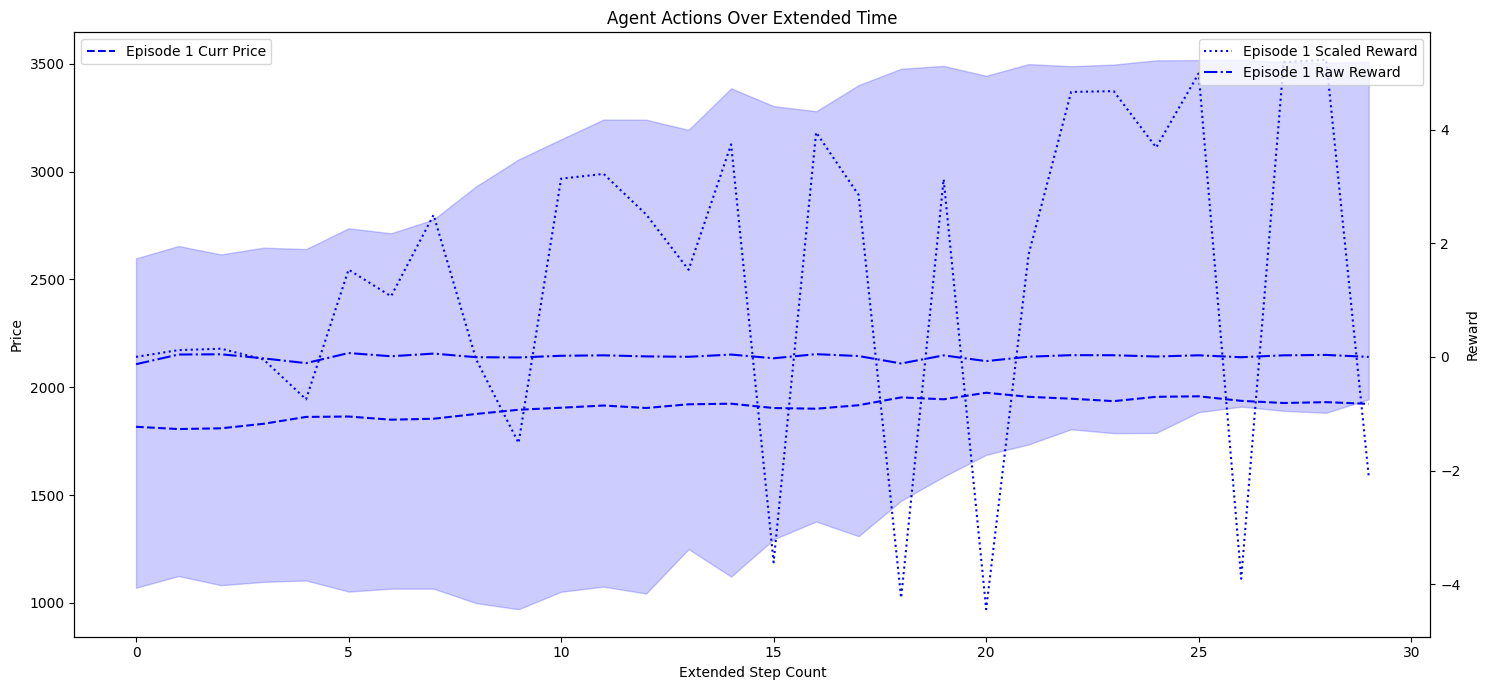

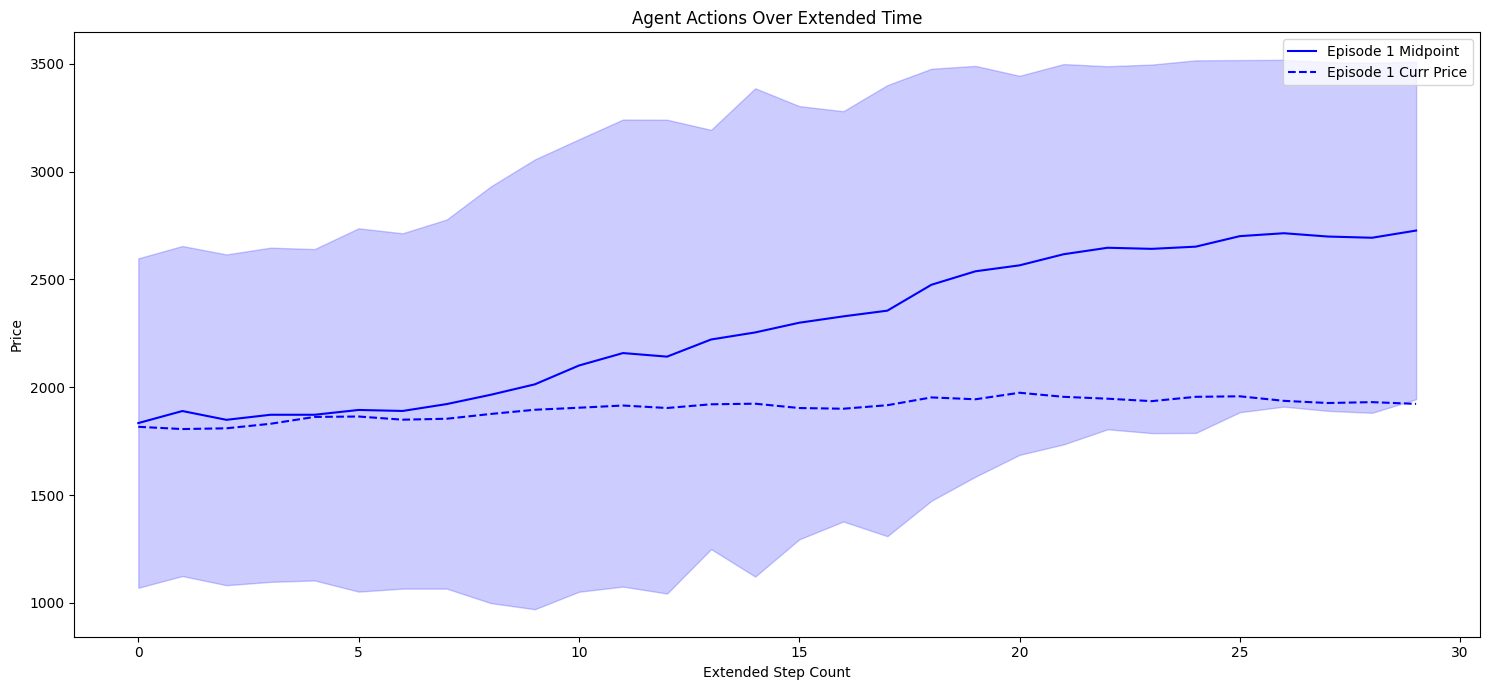

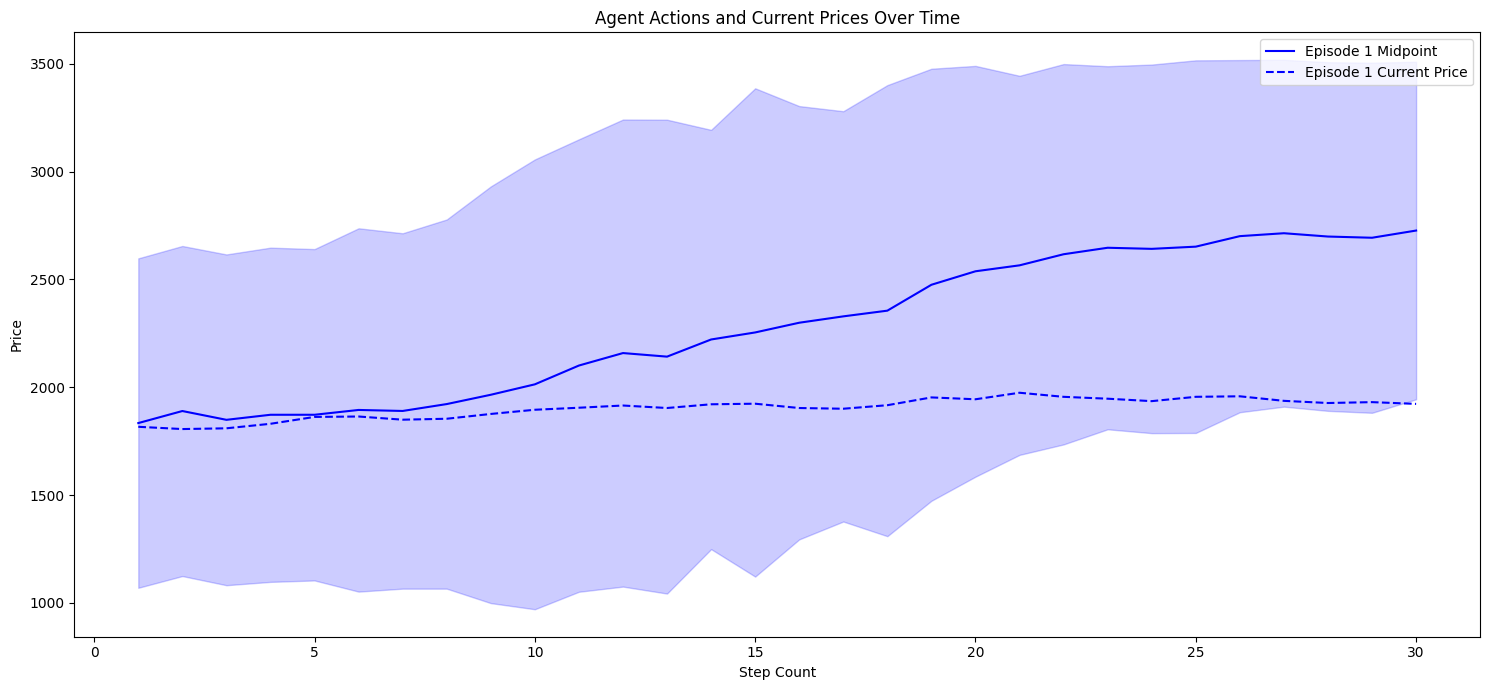

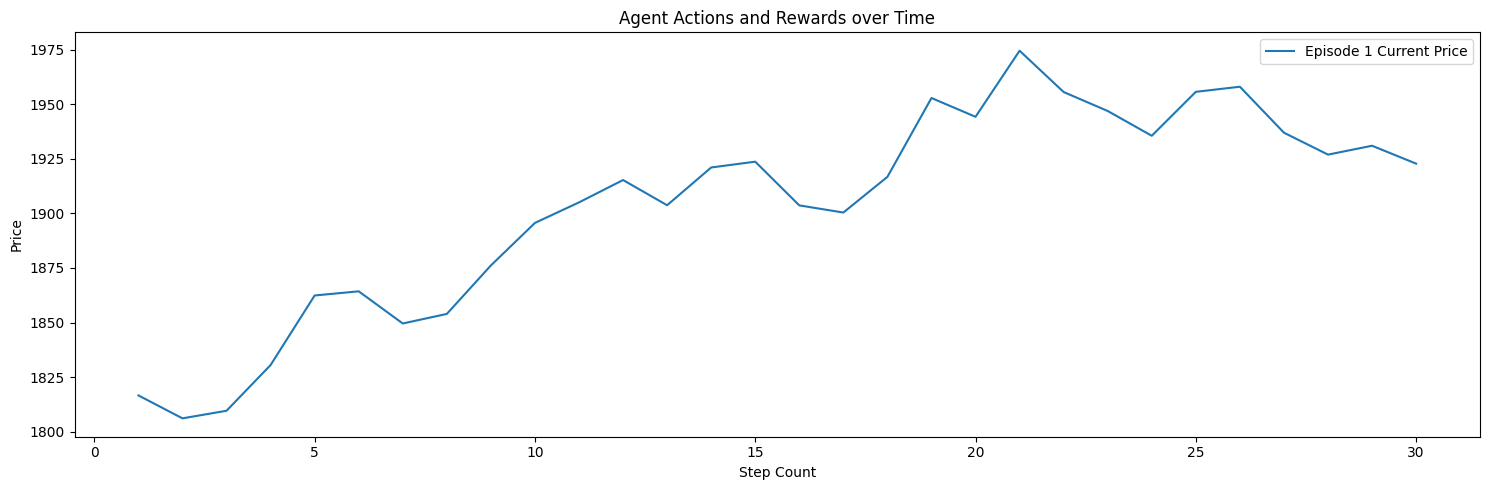

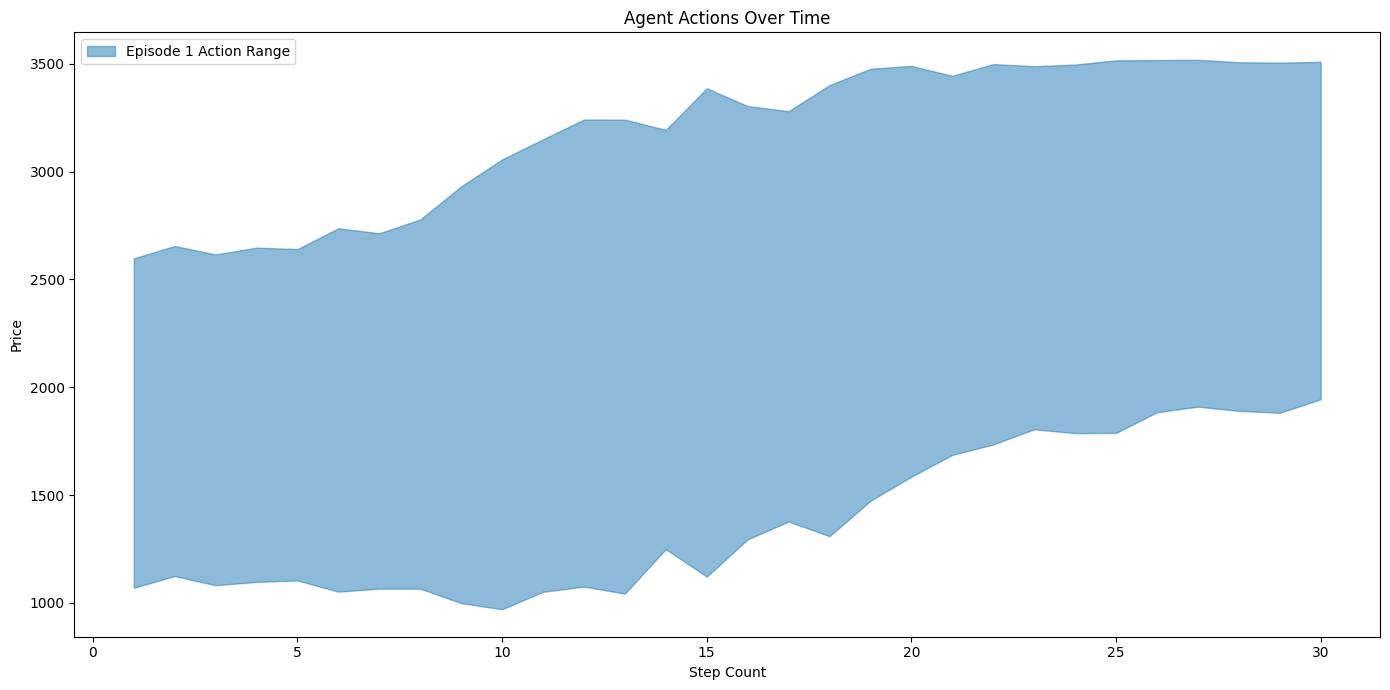

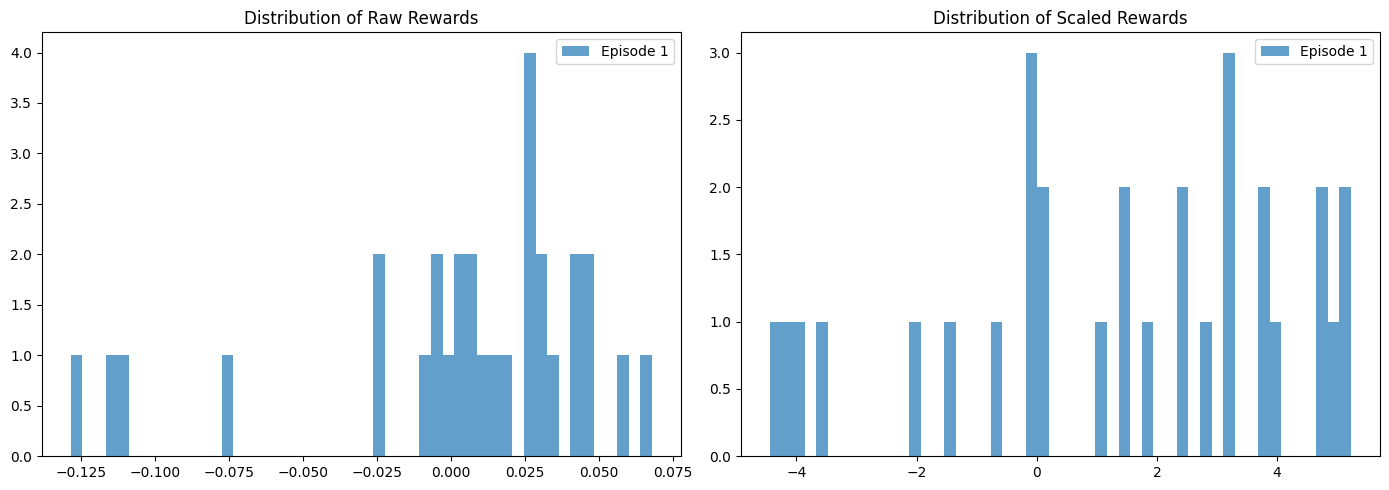

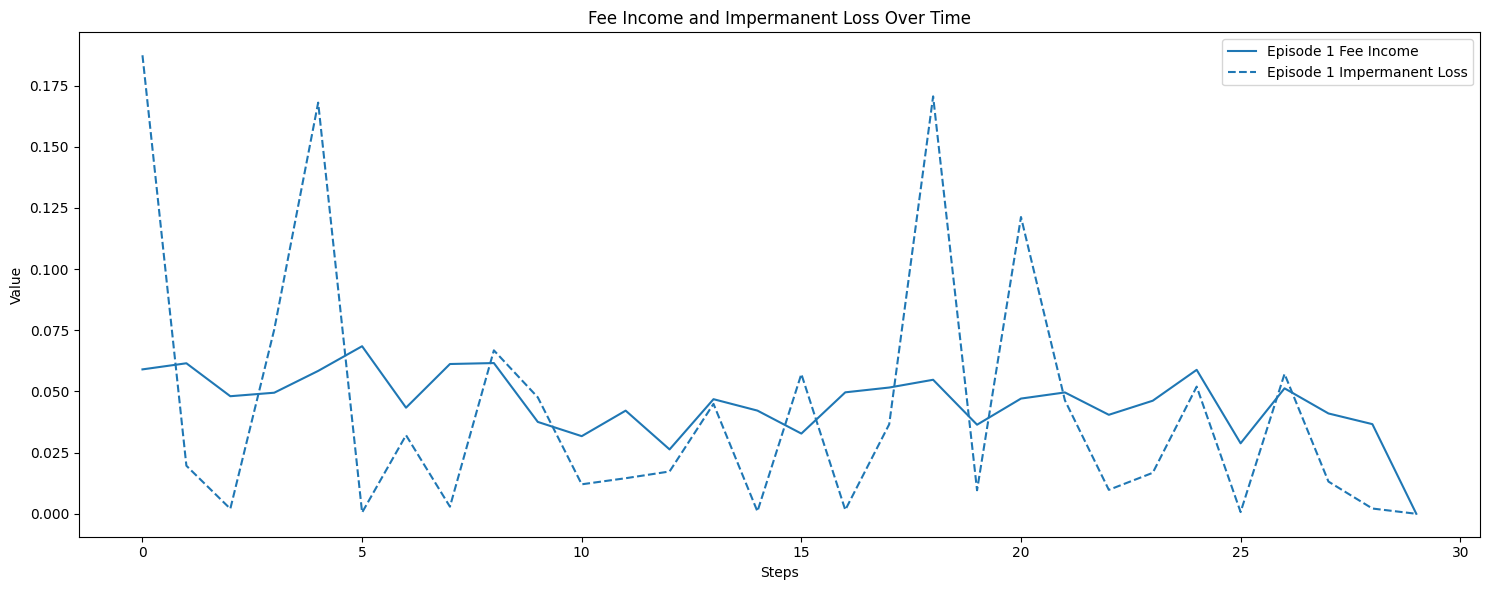

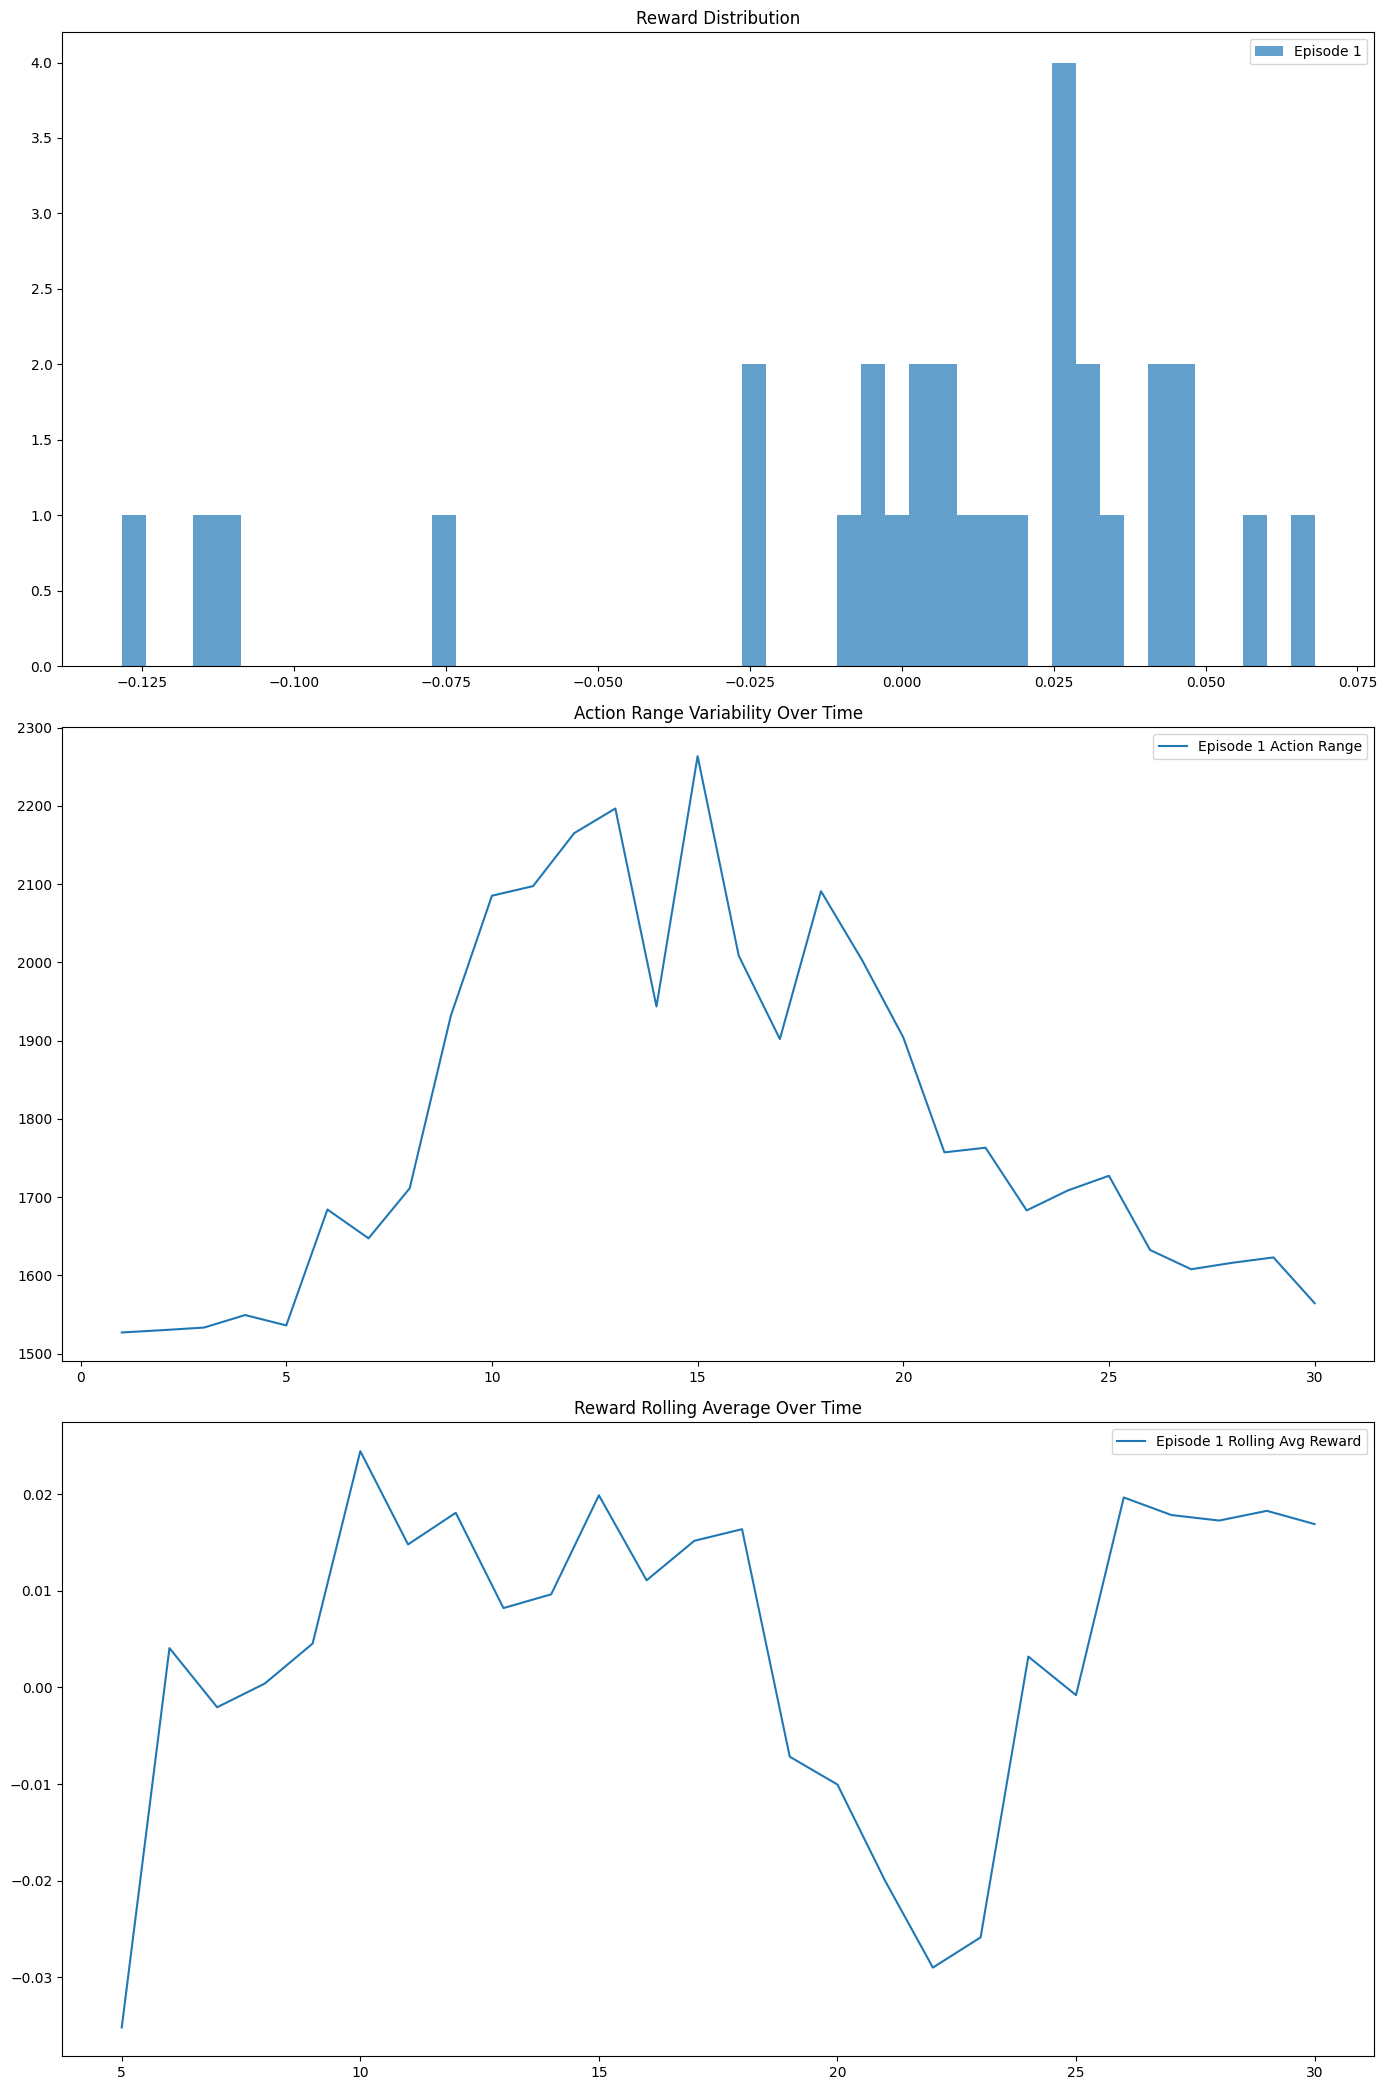

In [19]:
plot_agent_performance_combined(data_df)
#plot_agent_performance(data_df)
#plot_agent_performance_overlay(data_df)
#plot_episode_data(data_df)

In [62]:
  %reload_ext tensorboard

In [63]:
%load_ext tensorboard
%tensorboard --logdir ./model_storage


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

## Save trained weights

In [20]:
# Saving the actor model weights
actor_model_path = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/actor_model_1_unbounded_action_space/'
agent.actor.save_weights(actor_model_path)

# Saving the critic model weights
critic_model_path = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage/critic_model_1_unbounded_action_space/'
agent.critic.save_weights(critic_model_path)


## Evaluation of trained RL agent with Baseline Performnace Analysis

### Eval Env

In [110]:
class DiscreteSimpleEnvEval(DiscreteSimpleEnv):
    def __init__(self, agent_budget_usd, percentage_range, seed=None):
        super().__init__(agent_budget_usd)
        self.percentage_range = percentage_range
        if seed is not None:
            np.random.seed(seed)
        self.cumulative_reward_rl_agent = 0
        self.cumulative_reward_baseline_agent = 0

    def _take_action(self, action):
        # Disable exploration noise
        self.exploration_std_dev = 0.0
        return super()._take_action(action)
    
    def step(self, raw_action_rl_agent):
        # The RL agent takes an action
        mint_tx_receipt_rl_agent, action_rl_agent = self._take_action(raw_action_rl_agent)
        raw_action_baseline_agent=self.baseline_agent_policy()
        # The baseline agent takes an action
        mint_tx_receipt_baseline_agent, action_baseline_agent = self._take_action_baseline(raw_action_baseline_agent)

        # Perform environment step
        print('Environment Step')
        self.engine.reset()
        self.engine.run()
        print()

        # Calculate rewards for both agents
        scaled_reward_rl_agent, raw_reward_rl_agent, fee_income_rl_agent, impermanent_loss_rl_agent = self._calculate_reward(action_rl_agent, mint_tx_receipt_rl_agent)
        scaled_reward_baseline_agent, raw_reward_baseline_agent, fee_income_baseline_agent, impermanent_loss_baseline_agent = self._calculate_reward(action_baseline_agent, mint_tx_receipt_baseline_agent)

        # Update cumulative rewards
        self.cumulative_reward_rl_agent += scaled_reward_rl_agent
        self.cumulative_reward_baseline_agent += scaled_reward_baseline_agent

        self.step_count+=1
        # Print rewards and cumulative rewards for both agents
        print(f"episode: {self.episode}, step_count: {self.step_count}")
        print(f"rl_agent_scaled_reward: {scaled_reward_rl_agent}, rl_agent_raw_reward: {raw_reward_rl_agent}, rl_agent_cumulative_reward: {self.cumulative_reward_rl_agent}")
        print(f"baseline_agent_scaled_reward: {scaled_reward_baseline_agent}, baseline_agent_raw_reward: {raw_reward_baseline_agent}, baseline_agent_cumulative_reward: {self.cumulative_reward_baseline_agent}")
        print(f"raw_pool_state: {self.pool.get_global_state()}")
        print(f"sclaed_pool_state: {self.state}")
        print()
      

        # Update the state and check if the episode is done
        self.state = self.get_obs_space()
        self.done = self._is_done()
        eval_data_log.append((self.episode, self.step_count, self.pool.get_global_state(), raw_action_rl_agent,action_rl_agent,raw_action_baseline_agent,action_baseline_agent, self.state, raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, self.cumulative_reward_rl_agent, self.cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent,fee_income_baseline_agent,impermanent_loss_baseline_agent))
        # Return the necessary information
        return self.state, raw_reward_rl_agent, self.done, {}
    
    def _take_action_baseline(self, action_dict):
        
        print('Baseline Agent Action')
        print(f"Baseline agent action: {action_dict}")

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd

        mint_tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return mint_tx_receipt,action_dict
    
    
    def  baseline_agent_policy(self):
        global_state = self.pool.get_global_state()
        raw_curr_price = global_state['curr_price']
        
        # Calculate the price range based on the raw current price
        lower_price = raw_curr_price * (1 - self.percentage_range)
        upper_price = raw_curr_price * (1 + self.percentage_range)

        action_baseline={
            'price_lower':lower_price,
            'price_upper':upper_price
        }

        #print(f'baseline policy: price_lower: {lower_price}, price_upper: {upper_price}')
        
        # Convert these price bounds to relative actions in 0-1 range
        #action_lower_rel = (lower_price - self.action_lower_bound) / ((self.action_upper_bound - self.action_lower_bound) / 2)
        #action_upper_rel = ((upper_price - self.action_lower_bound) / ((self.action_upper_bound - self.action_lower_bound) / 2))
        
        #action_baseline_agent = np.array([[action_lower_rel, action_upper_rel]], dtype=np.float32)
        #action_baseline_agent_tensor = tf.convert_to_tensor(action_baseline_agent, dtype=tf.float32)
        
        return action_baseline

class DDGPEval(DDPG):
    def choose_action(self, state):
        # Disable exploration noise
        action = super().choose_action(state)
        return action


### Evaluate

In [111]:
eval_data_log=[]
eval_env = DiscreteSimpleEnvEval(agent_budget_usd=1000,percentage_range=0.1, seed=42)
eval_agent = DDGPEval(alpha=0.001, beta=0.002, input_dims=input_dims, tau=0.2, env=eval_env,
                      n_actions=n_actions, layer1_size=400, layer2_size=300, batch_size=5)

# Loading the actor model weights
loaded_actor = Actor(n_actions=n_actions)
sample_state = np.random.random((1, input_dims))
loaded_actor(sample_state)
status=loaded_actor.load_weights(actor_model_path)
status.expect_partial()

# Loading the critic model weights
loaded_critic = Critic(n_actions=n_actions)
sample_action = np.random.random((1, n_actions))
loaded_critic(sample_state, sample_action)  # Pass state and action separately
status=loaded_critic.load_weights(critic_model_path)
status.expect_partial()

In [112]:
n_evaluation_episodes = 1
max_steps_per_episode = 10

cumulative_rewards = []
actions_taken = []
states_visited = []

for episode in range(n_evaluation_episodes):
    state = eval_env.reset()
    episode_reward = 0
    
    for step in range(max_steps_per_episode):
        action = eval_agent.choose_action(state)
        next_state, reward, done, _ = eval_env.step(action)
        
        episode_reward += reward
        actions_taken.append(action)
        states_visited.append(state)
        
        state = next_state
        if done:
            break
    
    cumulative_rewards.append(episode_reward)
    print(f"Episode {episode+1}/{n_evaluation_episodes}, Reward: {episode_reward}")

# Analysis and Visualization
average_reward = np.mean(cumulative_rewards)
print(f"Average Reward: {average_reward}")

Pool selcted for this episode: WETH_USDC_3000
mnemonic: 'market exclude ordinary run invest element flush feel ribbon erosion carpet day'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0xf5C9Ba386A6F9eAEA1Baa75B27fa443cB54c6caF'), ('value', 1000000000000000019884624838656)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0xf5C9Ba386A6F9eAEA1Baa75B27fa443cB54c6caF'), ('value', 110000000000000000498458871988224)])]}
mnemonic: 'connect equal juice mobile warrior twenty rapid pave save copy iron absurd'
funded account with token0: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0xB897B5139F76E522e81827d0A75ec1525cAa813b'), ('value', 4999999999999999727876154935214080)])]}
funded account with token1: {'Transfer': [OrderedDict([('from', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('to', '0xB897B5139F76E

### Eval Visualization

In [104]:
df_eval_data = []

for entry in eval_data_log:
    (episode, step_count, global_state, raw_action_rl_agent, action_rl_agent, 
     raw_action_baseline_agent, action_baseline_agent, state, 
     raw_reward_rl_agent, raw_reward_baseline_agent,scaled_reward_rl_agent,scaled_reward_baseline_agent, cumulative_reward_rl_agent, 
     cumulative_reward_baseline_agent, fee_income_rl_agent, impermanent_loss_rl_agent, 
     fee_income_baseline_agent, impermanent_loss_baseline_agent) = entry
    
    # Extract raw_action values for RL agent
    raw_action_rl_agent_0 = float(raw_action_rl_agent[0][0].numpy())
    raw_action_rl_agent_1 = float(raw_action_rl_agent[0][1].numpy())

    scaled_action_rl_agent_0 = action_rl_agent['price_lower']
    scaled_action_rl_agent_1 = action_rl_agent['price_upper']
    
    # Extract raw_action values for baseline agent
    raw_action_baseline_agent_0 = raw_action_baseline_agent['price_lower']
    raw_action_baseline_agent_1 = raw_action_baseline_agent['price_upper']
    
    # Combine all data into a single dictionary
    data = {
        'episode': episode,
        'step_count': step_count,
        'raw_reward_rl_agent': raw_reward_rl_agent,
        'scaled_reward_rl_agent':scaled_reward_rl_agent,
        'cumulative_reward_rl_agent': cumulative_reward_rl_agent,
        'scaled_action_rl_agent_0':scaled_action_rl_agent_0,
        'scaled_action_rl_agent_1':scaled_action_rl_agent_1,
        'fee_income_rl_agent': fee_income_rl_agent,
        'impermanent_loss_rl_agent': impermanent_loss_rl_agent,
        'raw_reward_baseline_agent': raw_reward_baseline_agent,
        'scaled_reward_baseline_agent,':scaled_reward_baseline_agent,
        'cumulative_reward_baseline_agent': cumulative_reward_baseline_agent,
        'raw_action_baseline_agent_0': raw_action_baseline_agent_0,
        'raw_action_baseline_agent_1': raw_action_baseline_agent_1,
        'fee_income_baseline_agent': fee_income_baseline_agent,
        'impermanent_loss_baseline_agent': impermanent_loss_baseline_agent,
        'raw_action_rl_agent_0': raw_action_rl_agent_0,
        'raw_action_rl_agent_1': raw_action_rl_agent_1,

    }
    
    # Add action, global_state, and state data
    
    data.update(global_state)
    data.update(state)
    
    df_eval_data.append(data)

eval_data_df = pd.DataFrame(df_eval_data)
eval_data_df.to_csv('model_outdir_csv/rl_agent_eval_data.csv', index=False)
eval_data_df


,episode,step_count,raw_reward_rl_agent,cumulative_reward_rl_agent,raw_action_rl_agent_0,raw_action_rl_agent_1,fee_income_rl_agent,impermanent_loss_rl_agent,raw_reward_baseline_agent,cumulative_reward_baseline_agent,...,feeGrowthGlobal0X128,feeGrowthGlobal1X128,liquidity_raw,blockTimestamp,tickCumulative,secondsPerLiquidityCumulativeX128,scaled_curr_price,scaled_liquidity,scaled_feeGrowthGlobal0x128,scaled_feeGrowthGlobal1x128
0,1,1,0.014155,0.0000,0.514864,0.4739,0.028887,0.014732,0.062415,0.034106,...,92982398516046328398214359931823378,184519606661284791372697985675200898585,85661397258191593018000,1726125463,2604657300644907,226495337224103219724094085,1.054091,1.054093,1.054093,1.054093
1,1,2,0.036937,-0.0022,0.514864,0.4739,0.044276,0.007339,0.169459,0.499652,...,93085238657973332470085911416872188,184628391222324585732645604619359256377,85304755964455274488000,1726384762,2604676800532423,226496365301608769062371258,0.307159,0.305724,-0.994356,-0.994419
